In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=11
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'BOL.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2013-03-31,9249,-8226,1023,508,846,1240,8252,11309,0,...,3889,0,1580,7079,4354,16919,796,-1017,273.0,2013-04-25
1,2013-06-30,8035,-7800,235,-100,79,1173,7475,10378,0,...,3139,0,3232,7787,4668,17970,33,-1509,273.0,2013-07-20
2,2013-09-30,8472,-7522,950,498,223,0,8170,10721,0,...,0,0,3422,8611,4138,18199,1586,-1150,273.0,2013-10-20
3,2013-12-31,8653,-7933,720,391,611,1048,8031,11164,0,...,3636,0,3957,9005,4346,18782,1090,-1294,273.0,2014-02-09
4,2014-03-31,8551,-8010,541,153,289,1261,8108,10998,0,...,3332,0,3999,8854,4413,18737,442,-867,273.0,2014-04-25


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
40,2023-03-31,2023-04-25,273.00,19962,-15872,4090,2541,13722,3721,25067,...,3517,102257,12361,0,427,17226,12301,41498,2871,-2918
41,2023-06-30,2023-07-20,273.00,18442,-16823,1619,521,3589,3200,25938,...,3619,97568,11654,0,2598,18891,11165,42376,449,-4219
42,2023-09-30,2023-10-20,273.00,19396,-16953,2443,1357,4219,3711,24137,...,3587,98032,10714,0,3776,18167,11723,42021,2392,-3590
43,2023-12-31,2024-02-09,273.00,20754,-18170,2585,1656,4978,3964,21987,...,3537,101957,10915,0,2962,18396,11462,38052,6471,-4804
44,2024-03-31,2024-04-22,273.47,18481,-16303,2178,1139,4272,3624,23356,...,3561,104189,10664,0,3981,18779,11380,45722,1935,-3444


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
40,2023-03-31,2023-04-25,273.00,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
41,2023-06-30,2023-07-20,273.00,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
42,2023-09-30,2023-10-20,273.00,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
43,2023-12-31,2024-02-09,273.00,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495
44,2024-03-31,2024-04-22,273.47,18481,-16303,2178,1139,4272,3624,23356,...,104189,10664,0,3981,18779,11380,45722,1935,-3444,10.376655


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
40,2023-03-31,2023-04-25,273.00,19962,-15872,4090,2541,13722,3721,25067,...,102257,12361,0,427,17226,12301,41498,2871,-2918,10.432528
41,2023-06-30,2023-07-20,273.00,18442,-16823,1619,521,3589,3200,25938,...,97568,11654,0,2598,18891,11165,42376,449,-4219,10.518236
42,2023-09-30,2023-10-20,273.00,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
43,2023-12-31,2024-02-09,273.00,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495
44,2024-03-31,2024-04-22,273.47,18481,-16303,2178,1139,4272,3624,23356,...,104189,10664,0,3981,18779,11380,45722,1935,-3444,10.376655


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2013-04-29,65.590698,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.57572,0.42428,0.0,0.0,0.0,0.0,0.110607,0.054925,0.0,0.0
1,2013-05-06,61.387798,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.57572,0.42428,0.0,0.0,0.0,0.0,0.110607,0.054925,0.0,0.0
2,2013-05-13,64.000610,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.57572,0.42428,0.0,0.0,0.0,0.0,0.110607,0.054925,0.0,0.0
3,2013-05-20,63.073071,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.57572,0.42428,0.0,0.0,0.0,0.0,0.110607,0.054925,0.0,0.0
4,2013-05-27,63.371216,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.57572,0.42428,0.0,0.0,0.0,0.0,0.110607,0.054925,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2013-04-29,65.590698,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.0,0.110607,0.054925,0.0,0.0,inf,0.779957,0.484005,0.918458,inf
1,2013-05-06,61.387798,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.0,0.110607,0.054925,0.0,0.0,inf,0.729979,0.452991,0.887444,inf
2,2013-05-13,64.000610,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.0,0.110607,0.054925,0.0,0.0,inf,0.761049,0.472272,0.906724,inf
3,2013-05-20,63.073071,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.0,0.110607,0.054925,0.0,0.0,inf,0.750020,0.465427,0.899880,inf
4,2013-05-27,63.371216,2013-03-31,9249.0,0.0,84.095238,273.0,0.0,0.0,846.0,...,0.0,0.110607,0.054925,0.0,0.0,inf,0.753565,0.467627,0.902080,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

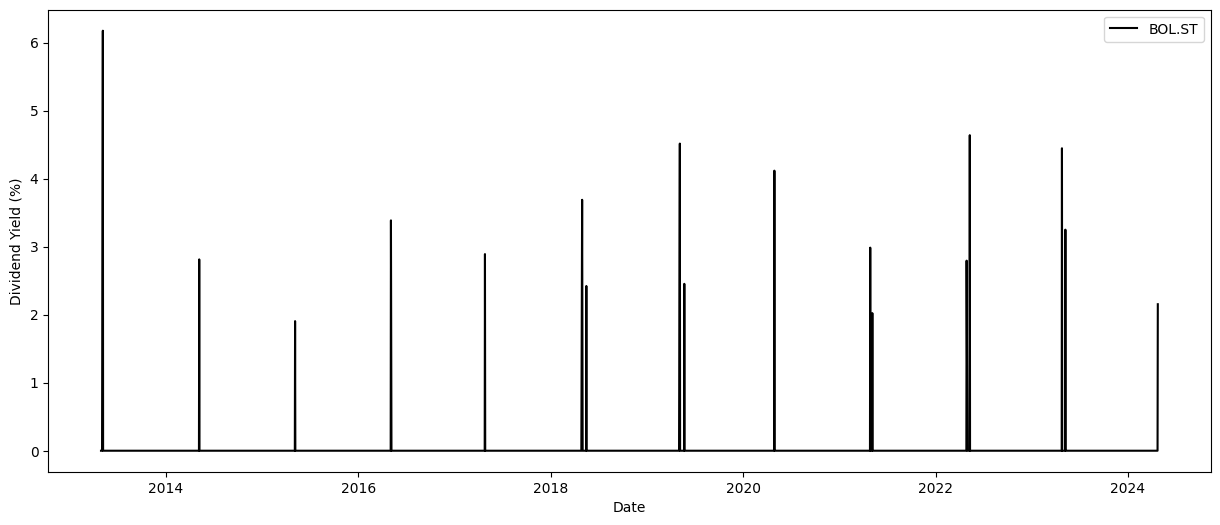

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.764539
share_price      1.000000
Name: share_price, dtype: float64


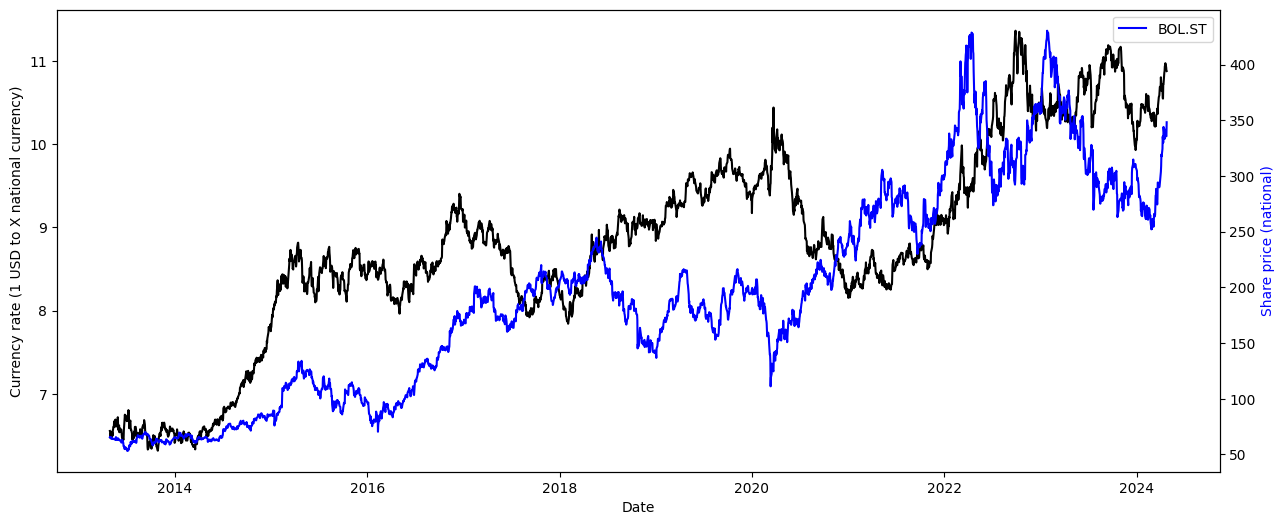

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

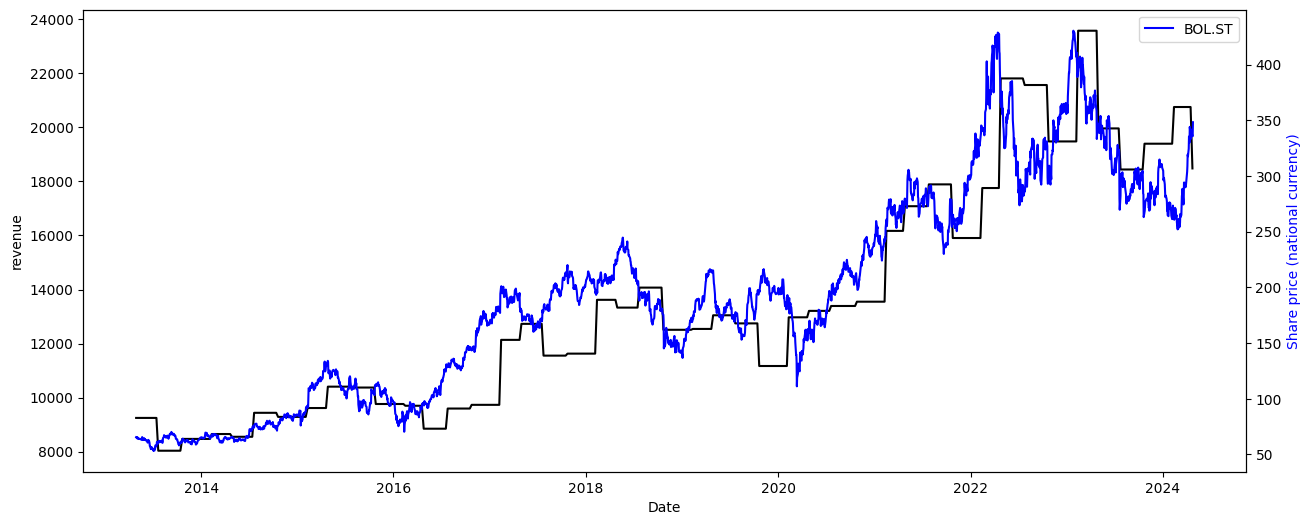

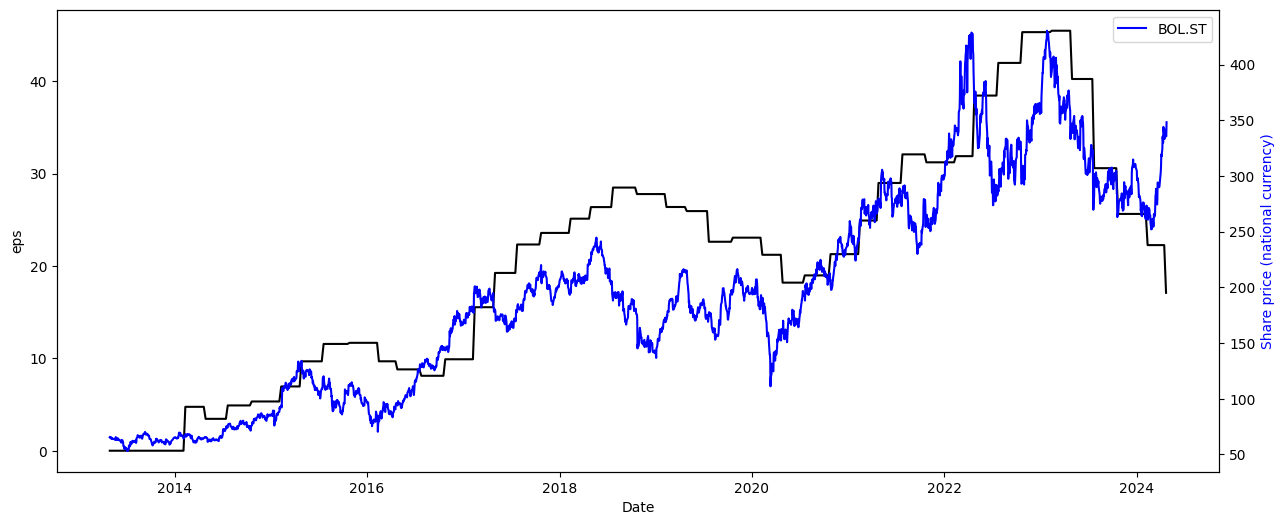

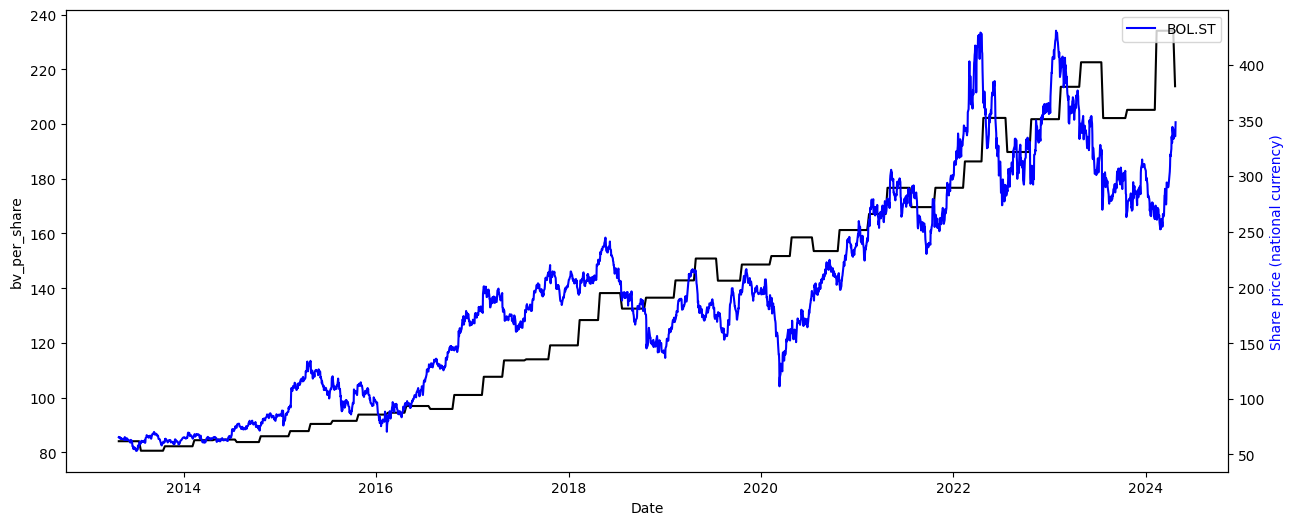

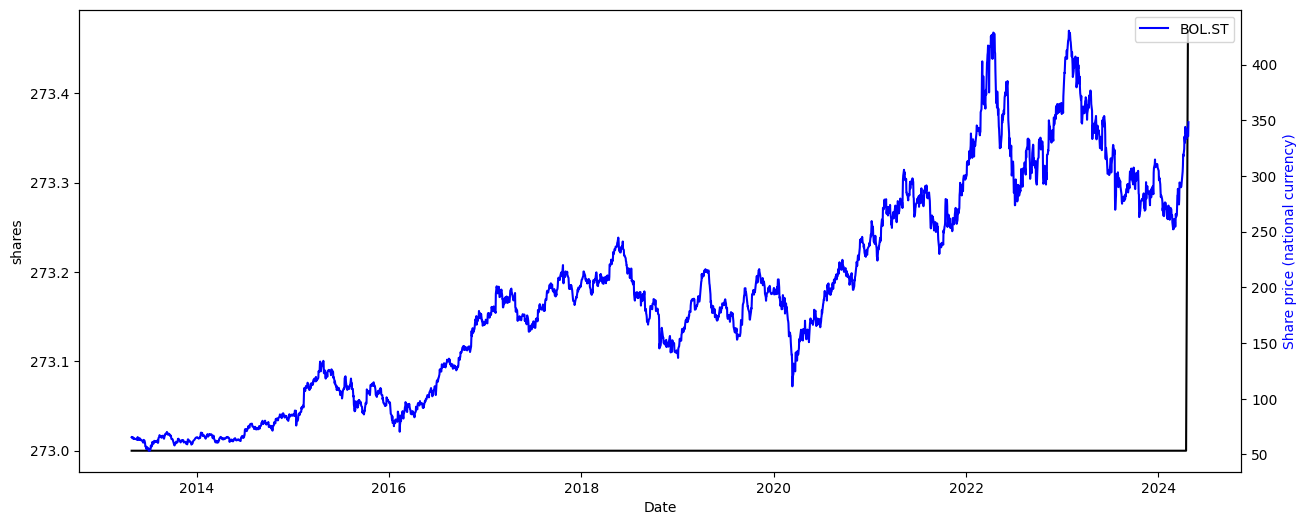

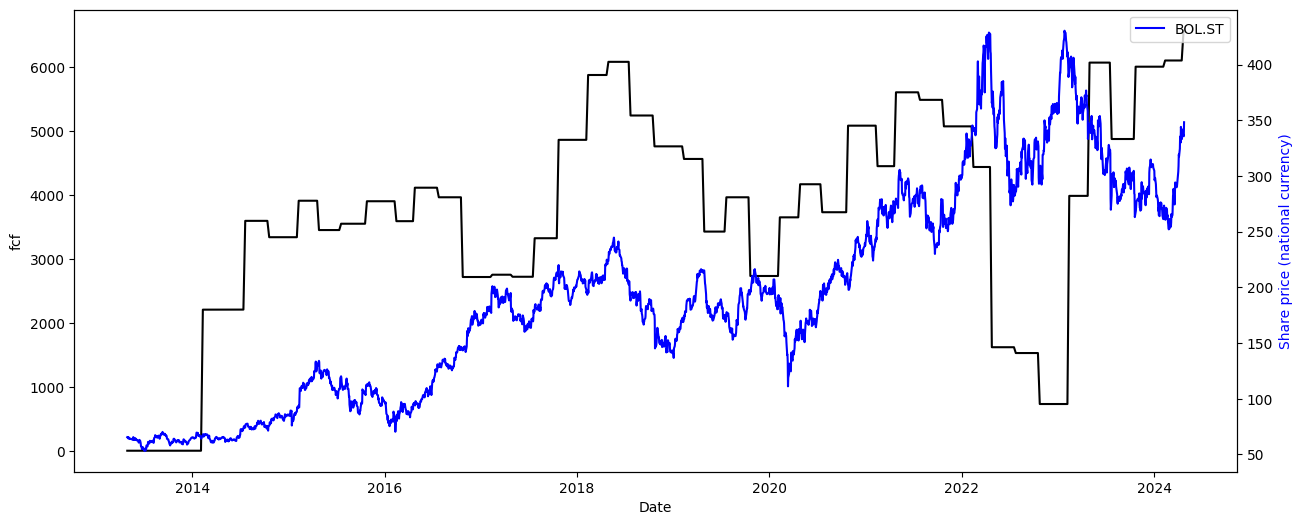

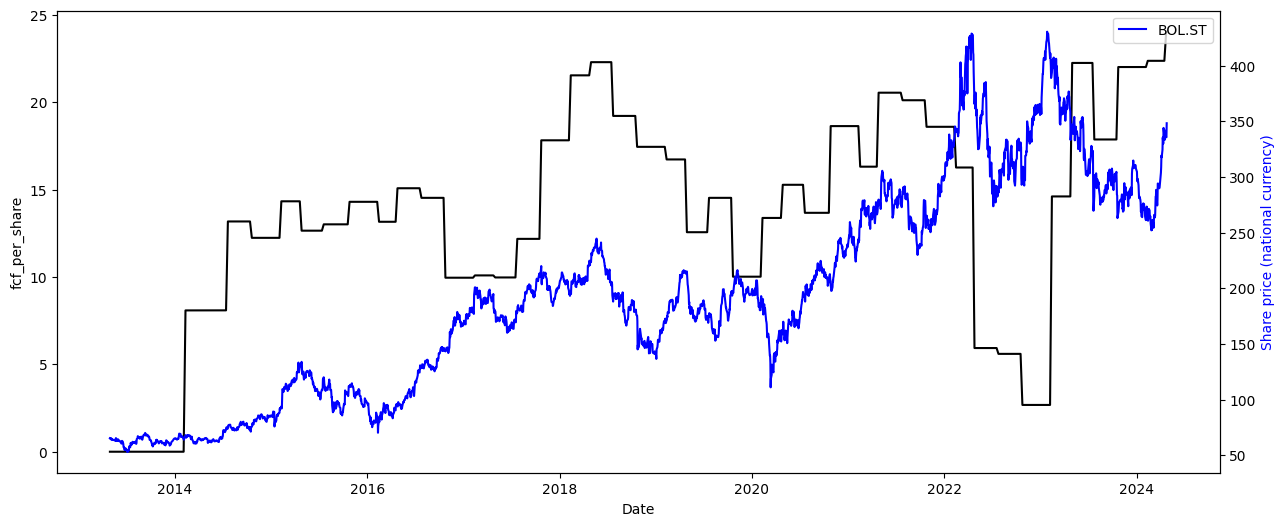

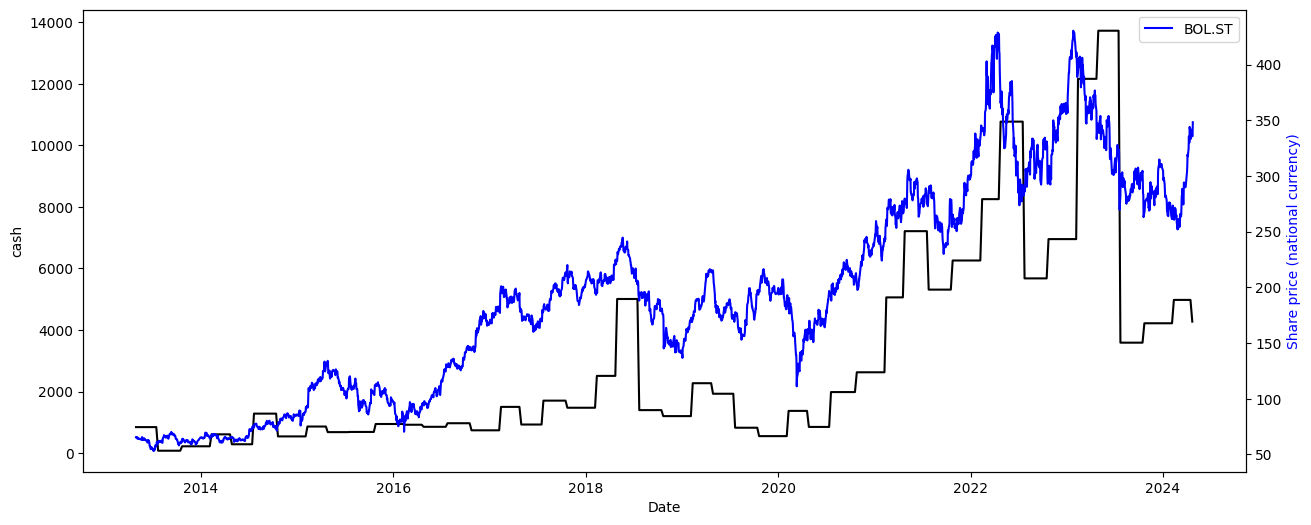

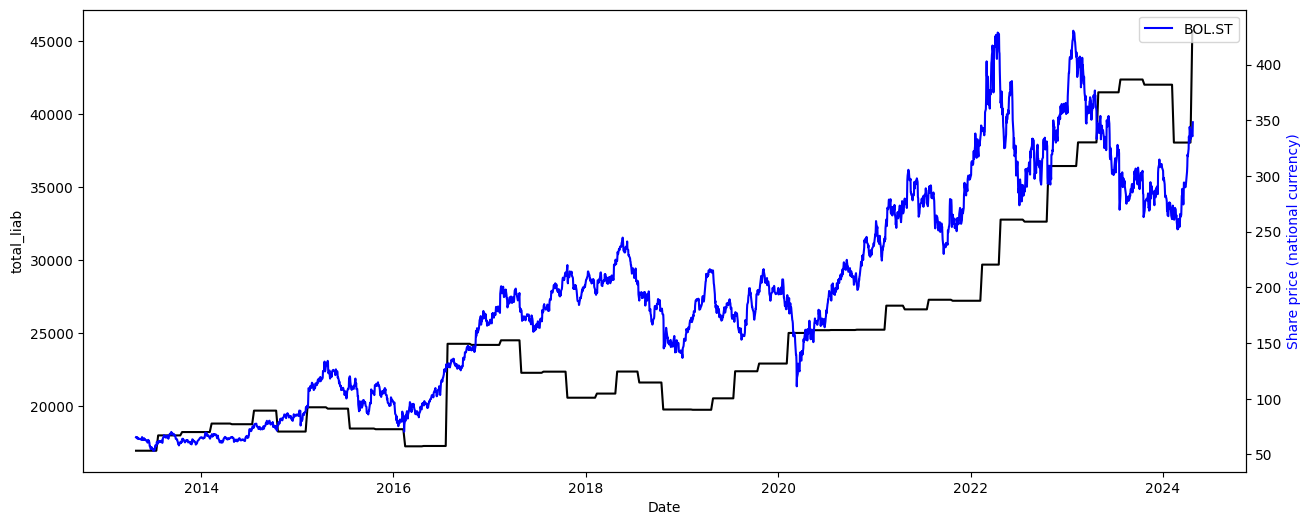

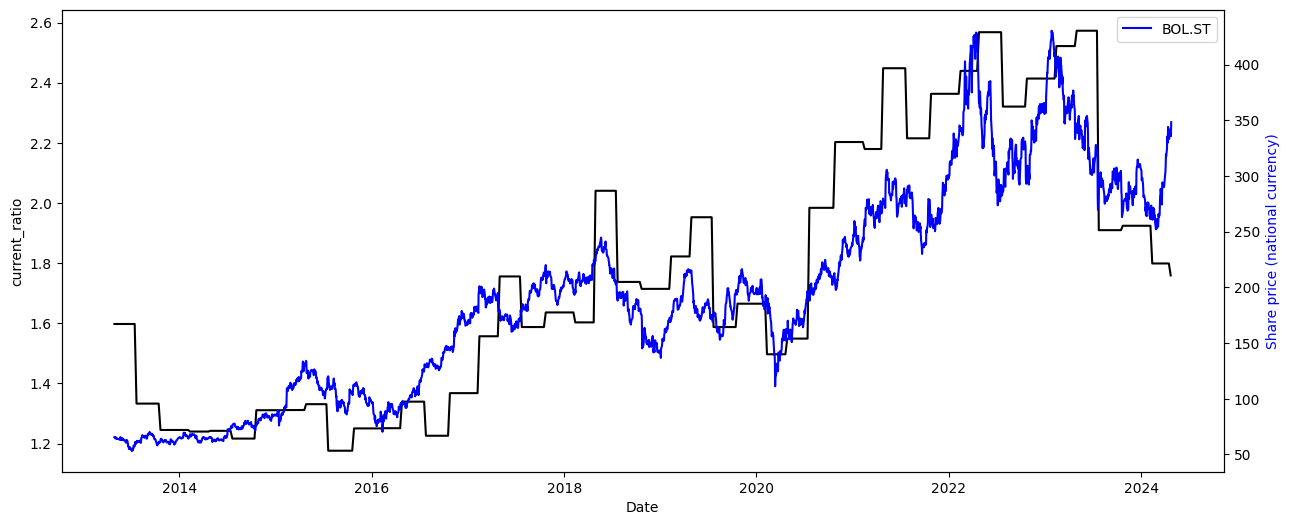

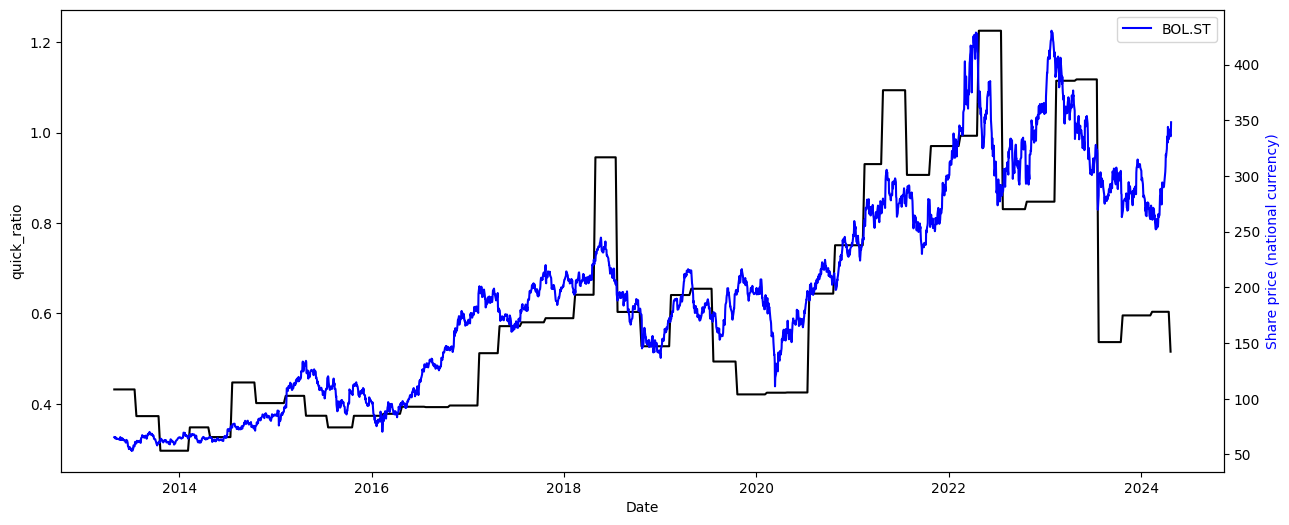

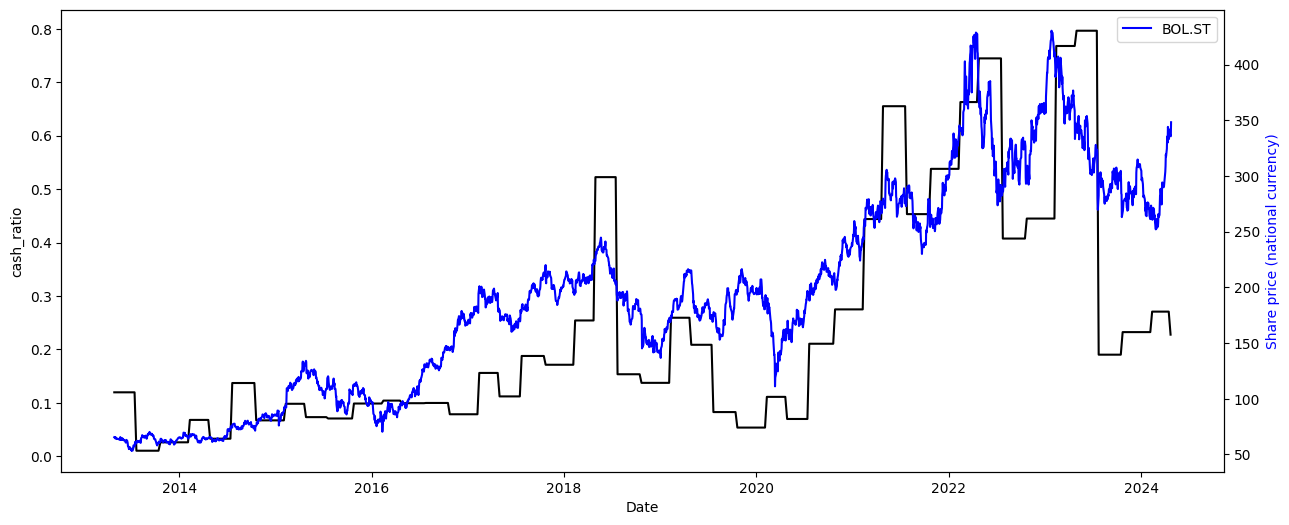

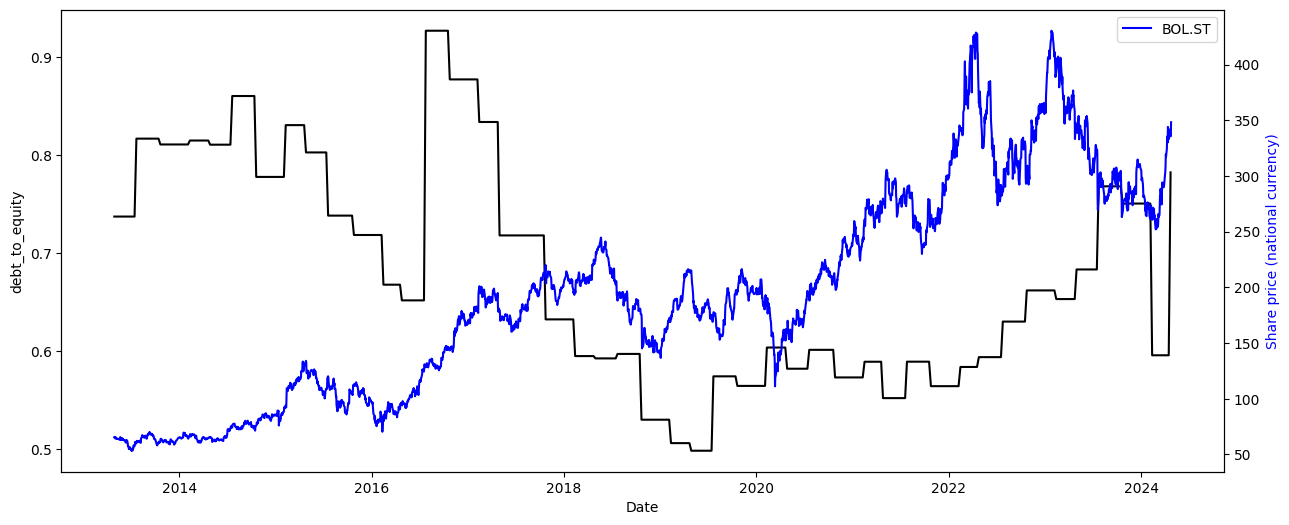

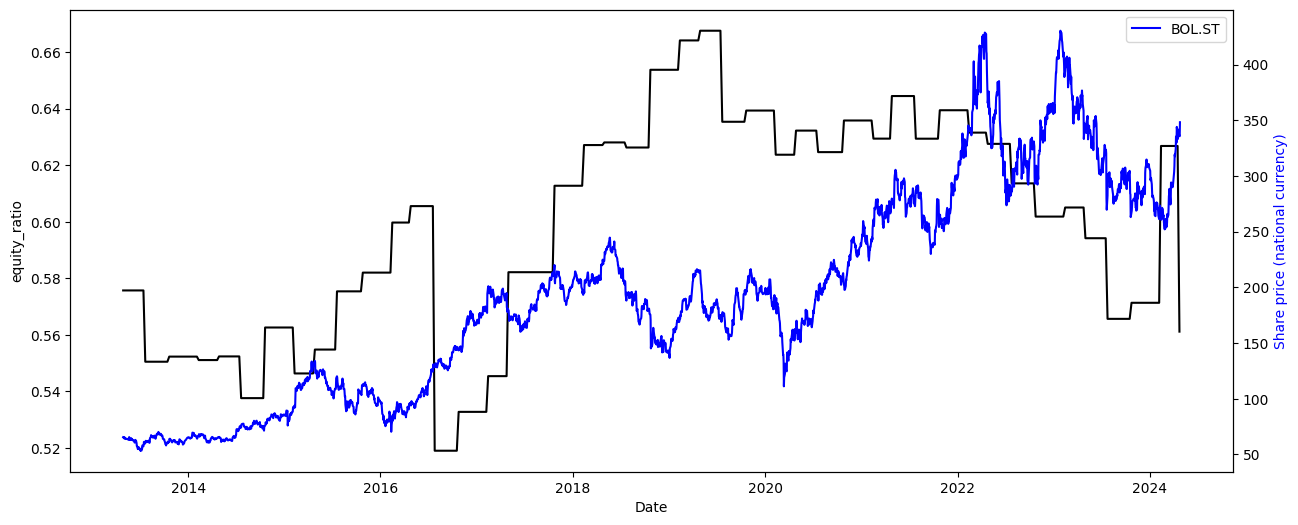

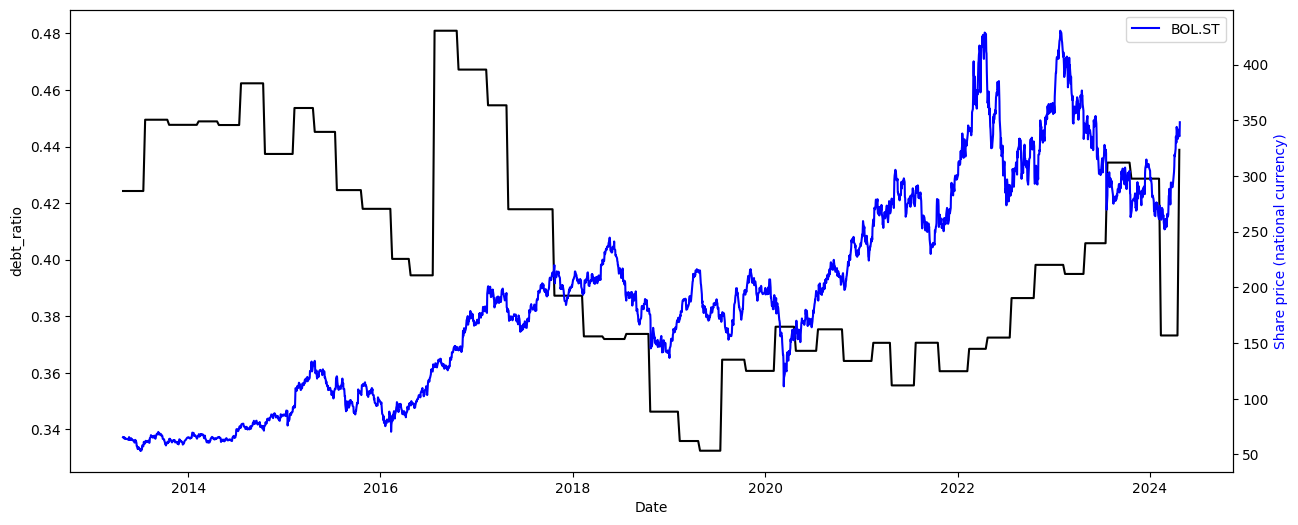

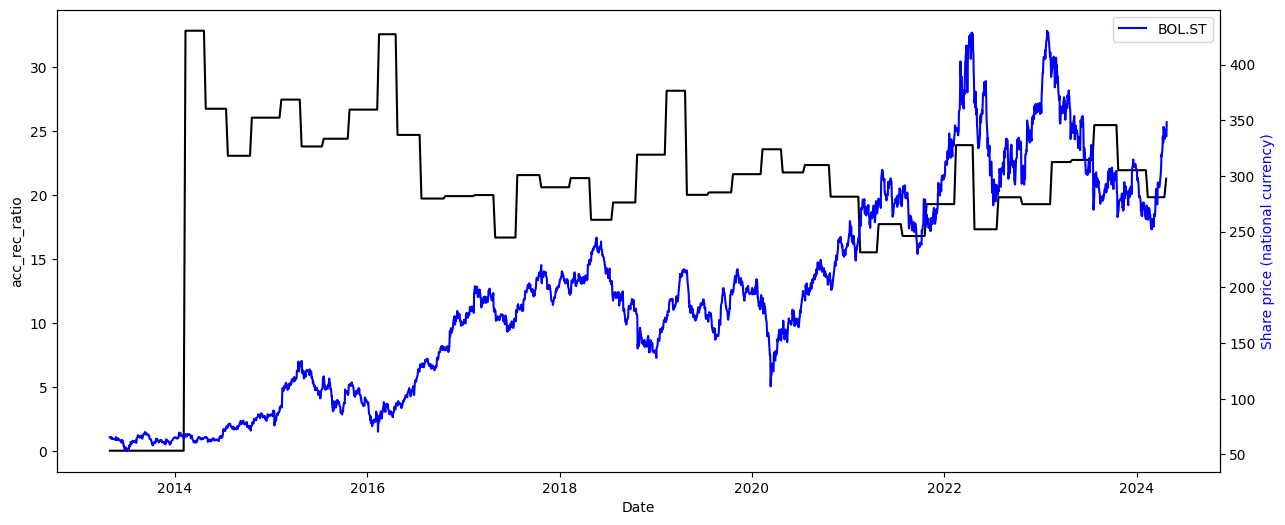

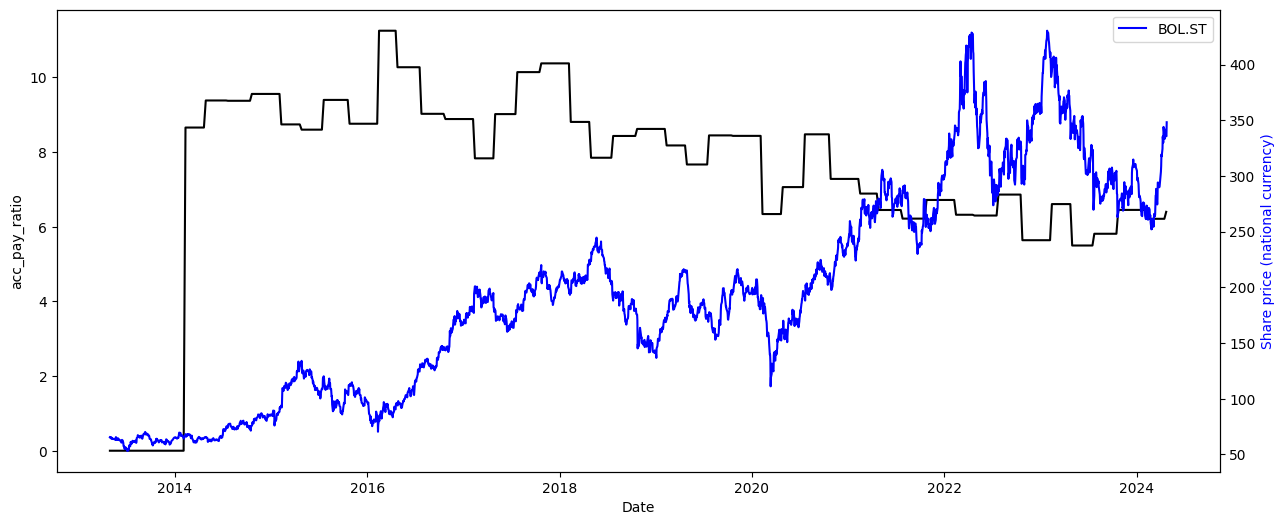

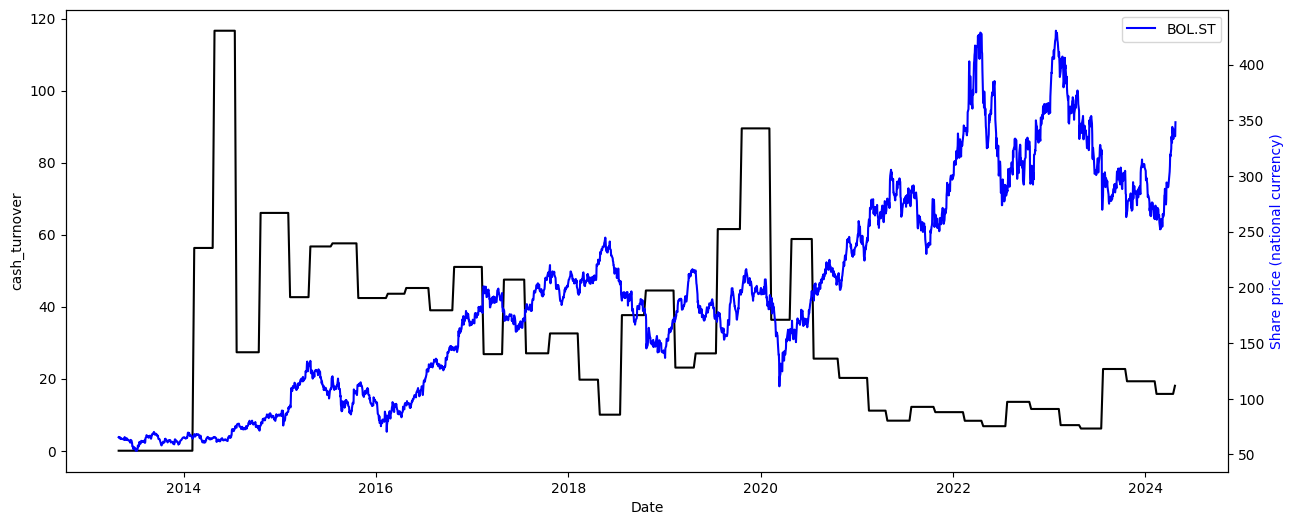

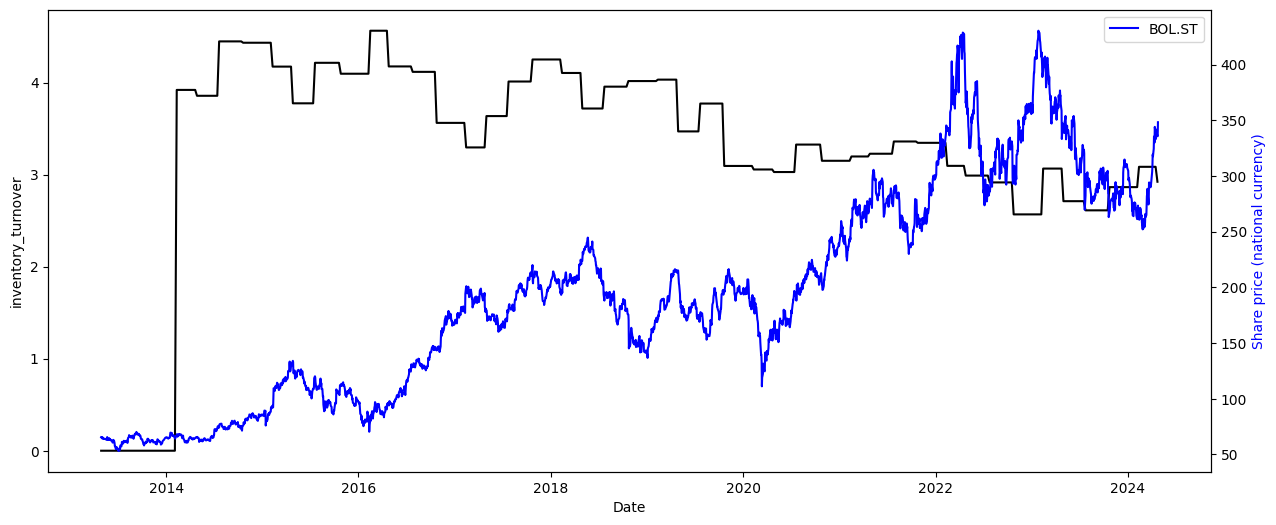

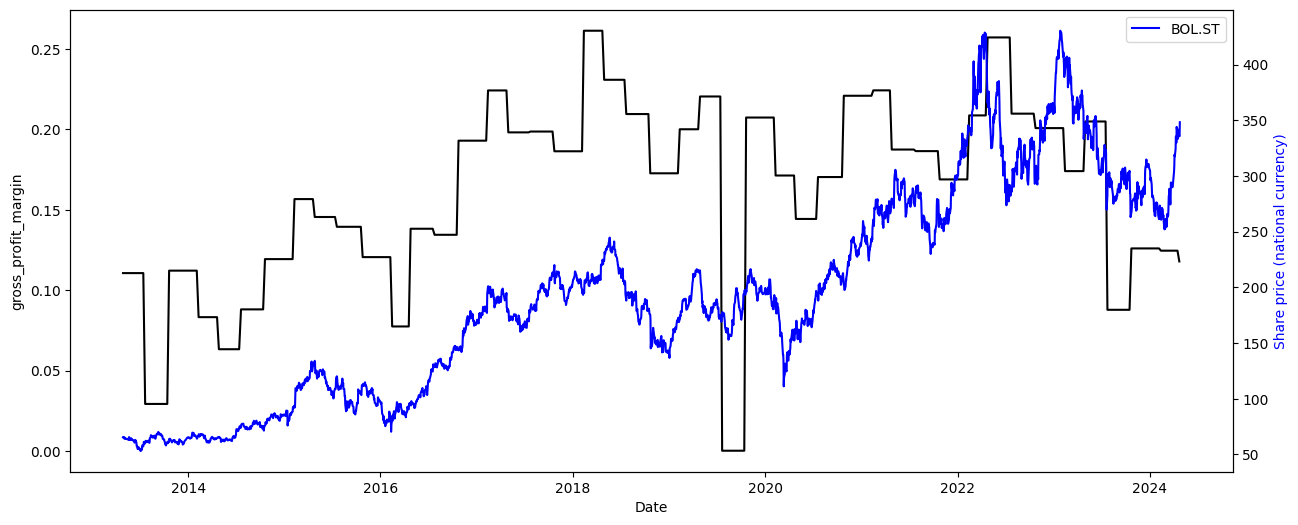

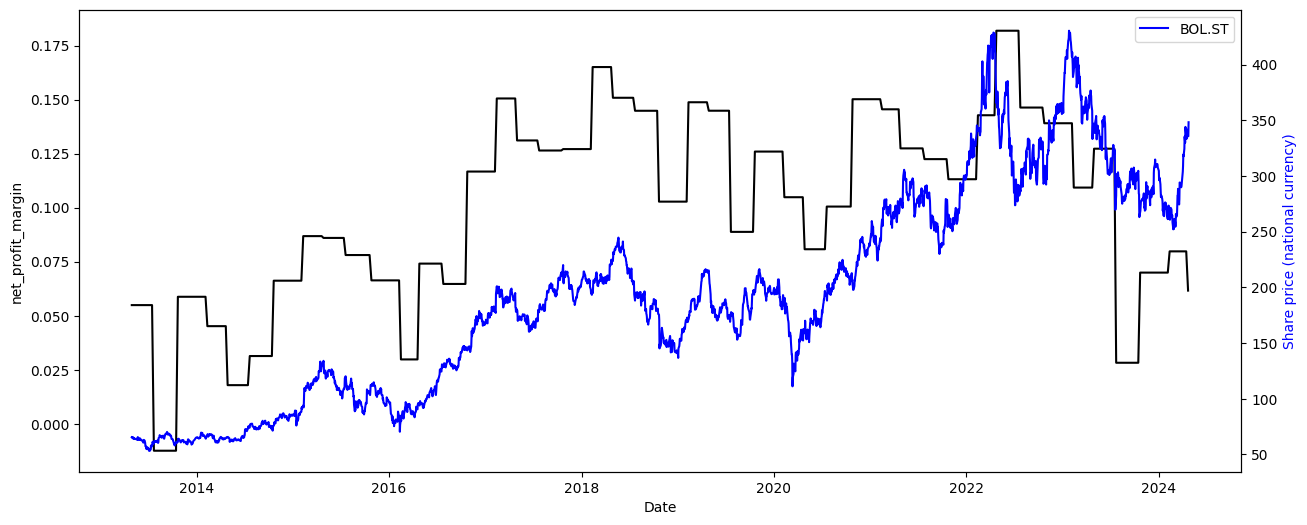

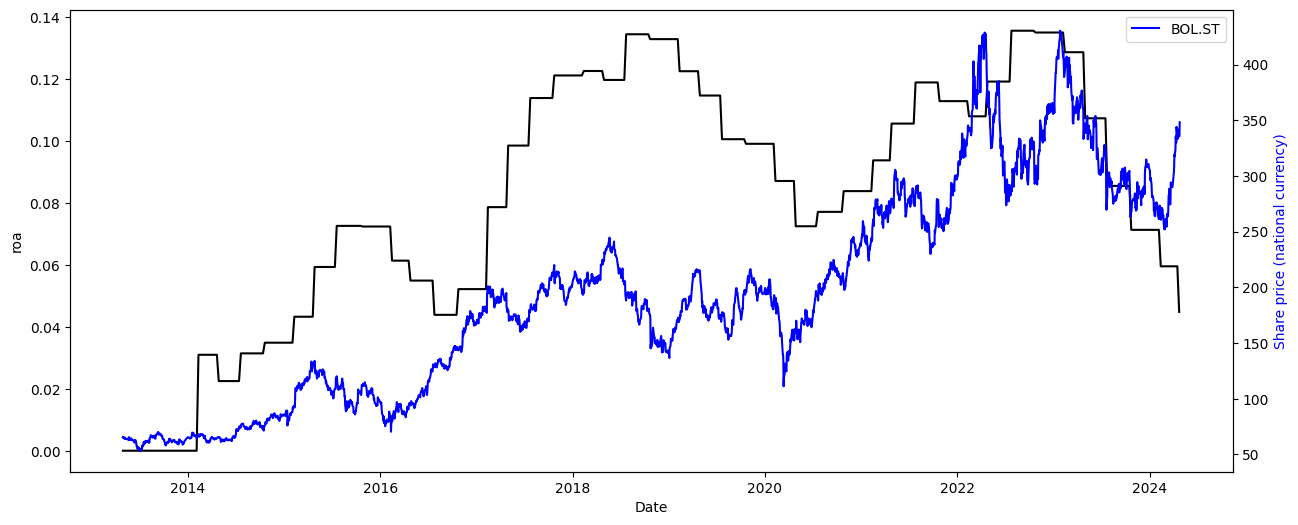

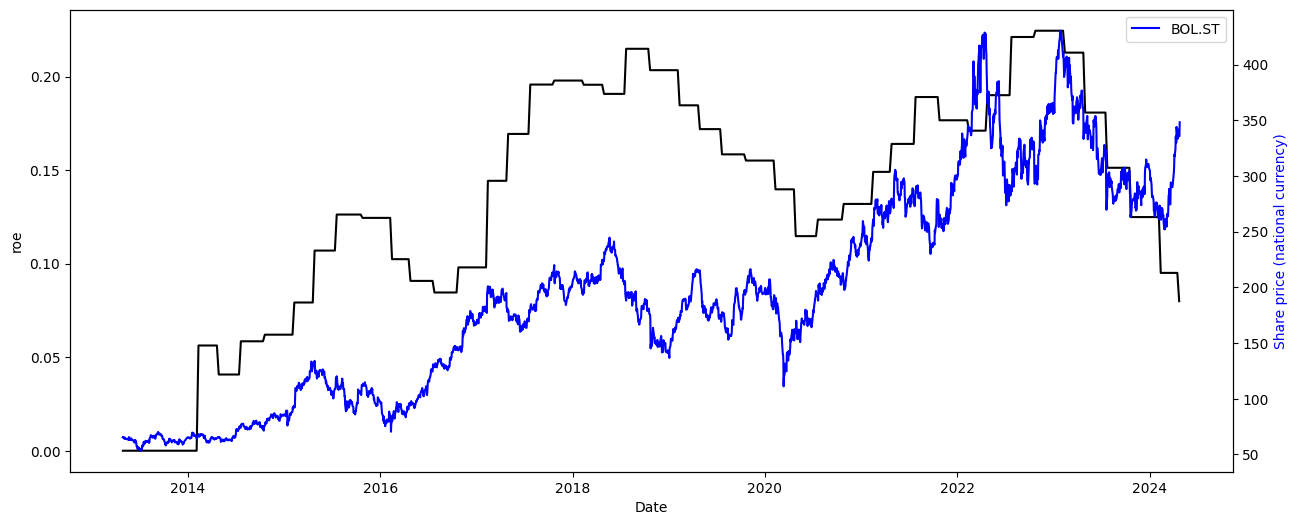

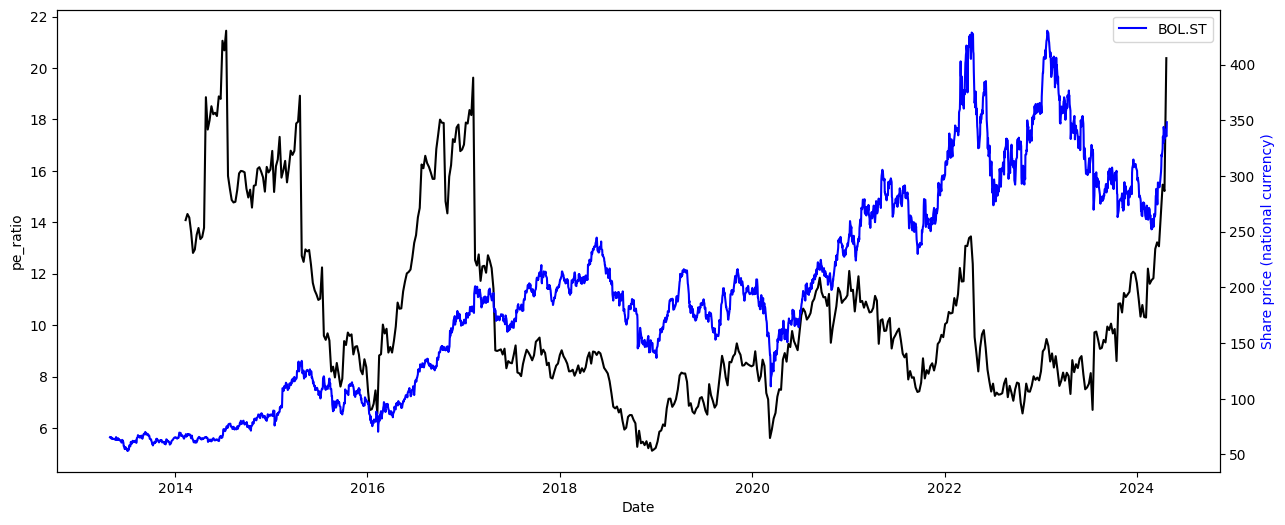

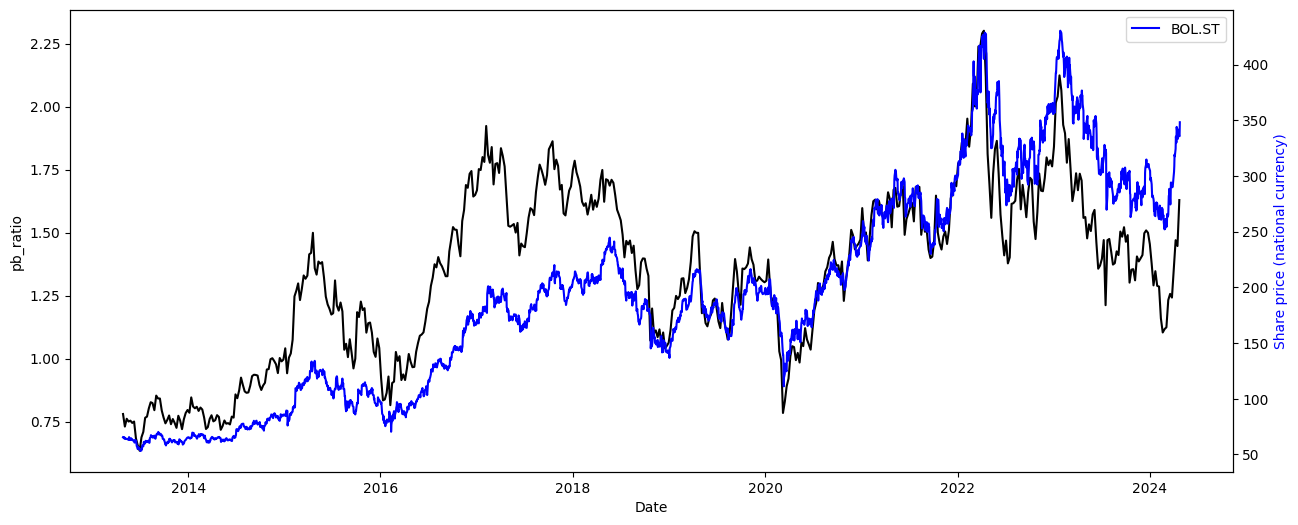

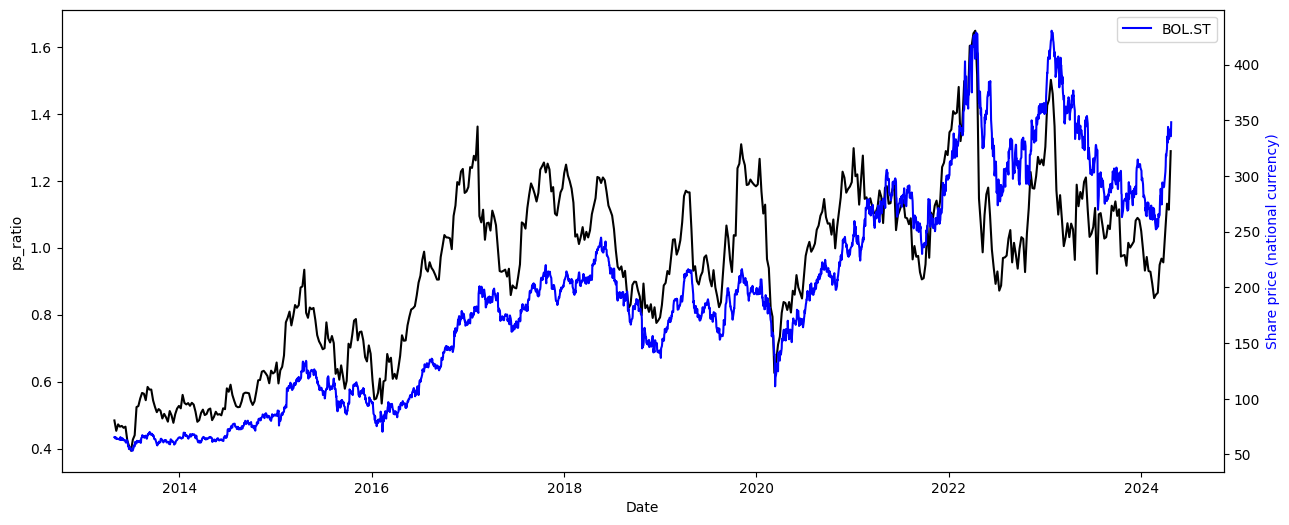

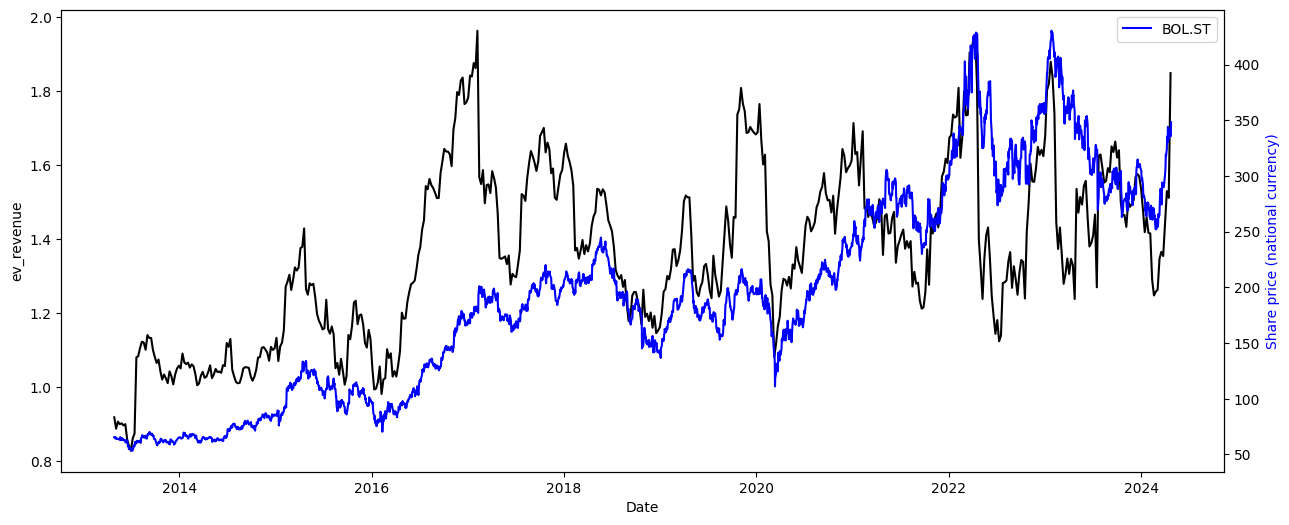

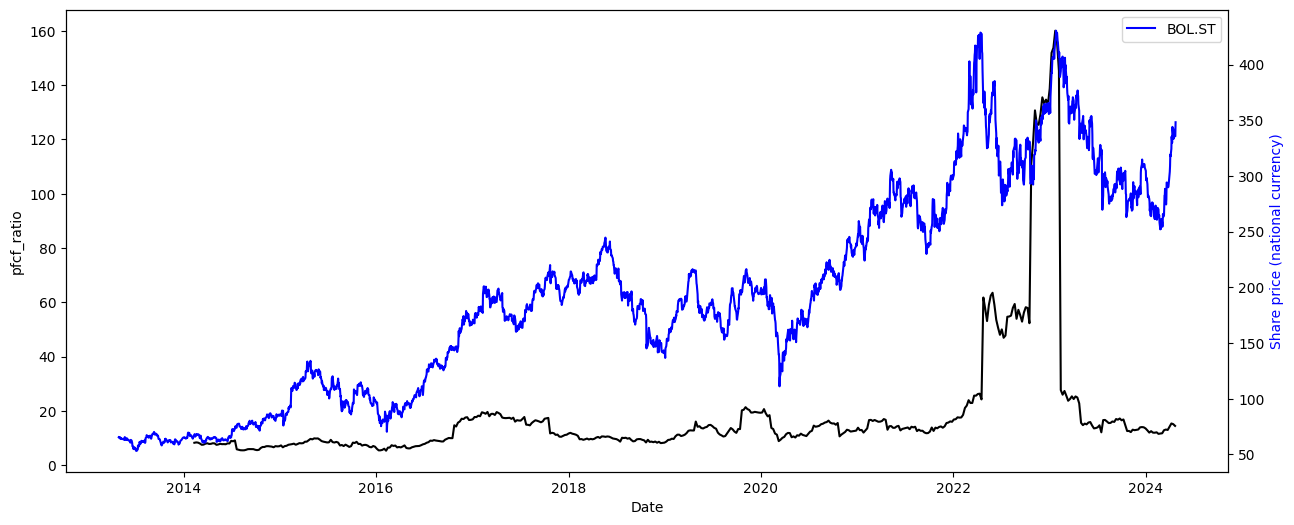

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

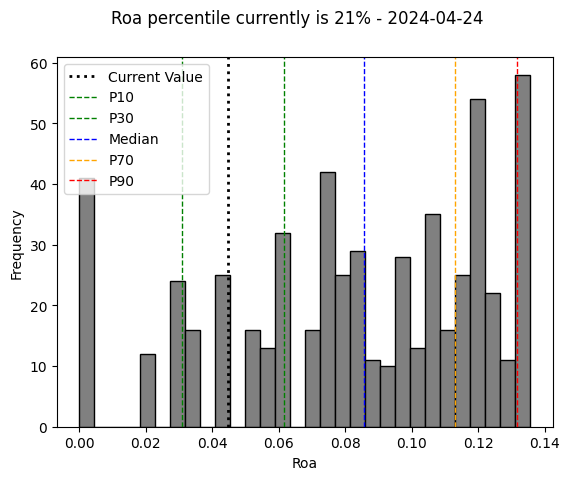

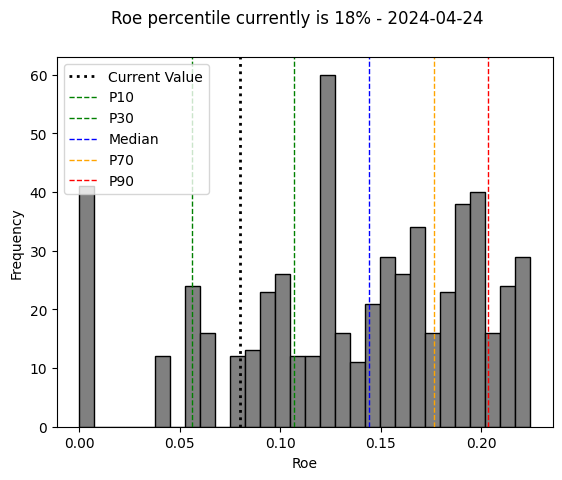

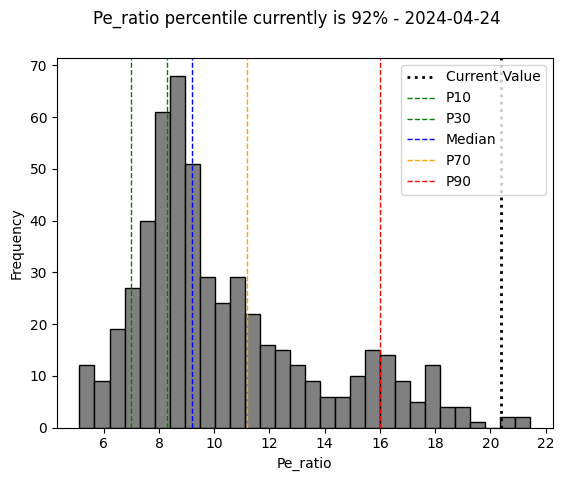

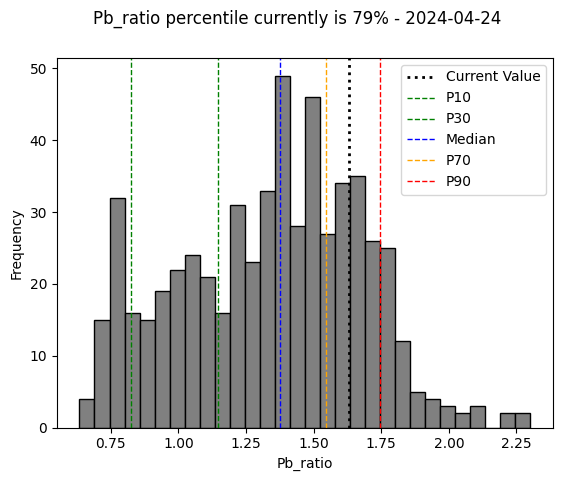

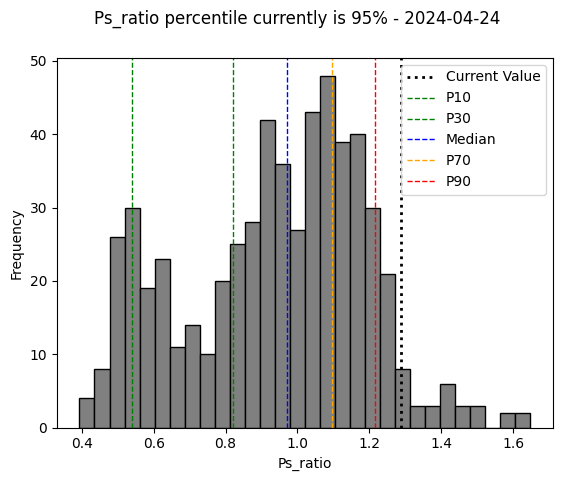

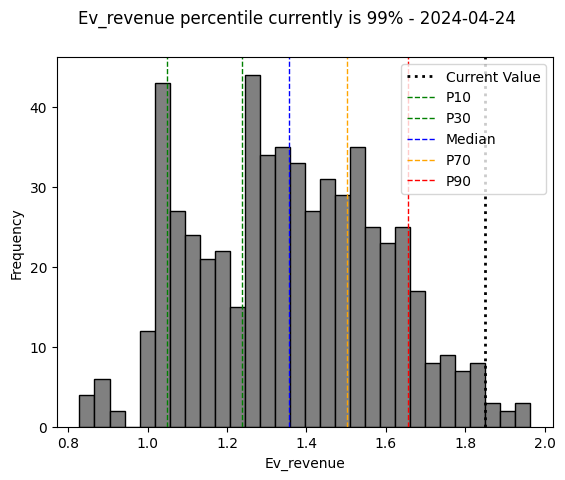

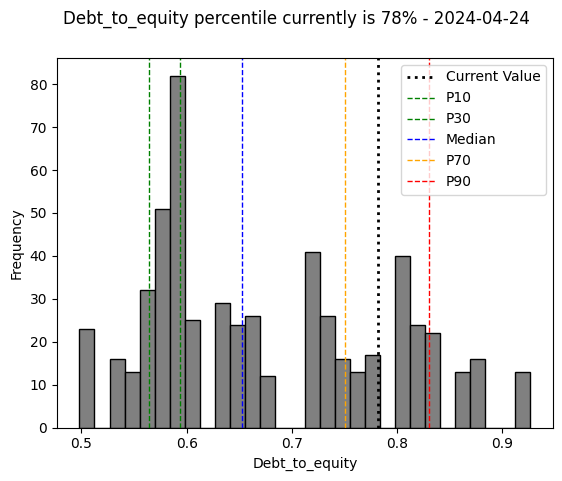

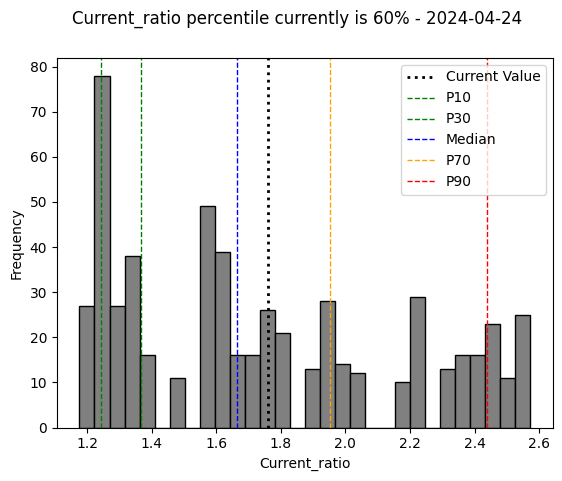

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.993812,-0.828939,0.696135,0.689881,0.471150,-0.720348,0.680981
roe,0.993812,1.000000,-0.810794,0.728765,0.700014,0.496438,-0.647090,0.663306
pe_ratio,-0.828939,-0.810794,1.000000,-0.149359,-0.197965,0.042352,0.722626,-0.442740
pb_ratio,0.696135,0.728765,-0.149359,1.000000,0.924400,0.831614,-0.289191,0.648622
ps_ratio,0.689881,0.700014,-0.197965,0.924400,1.000000,0.939521,-0.449160,0.671510
ev_revenue,0.471150,0.496438,0.042352,0.831614,0.939521,1.000000,-0.204372,0.443825
debt_to_equity,-0.720348,-0.647090,0.722626,-0.289191,-0.449160,-0.204372,1.000000,-0.599275
current_ratio,0.680981,0.663306,-0.442740,0.648622,0.671510,0.443825,-0.599275,1.000000


1 timestemos have been found!


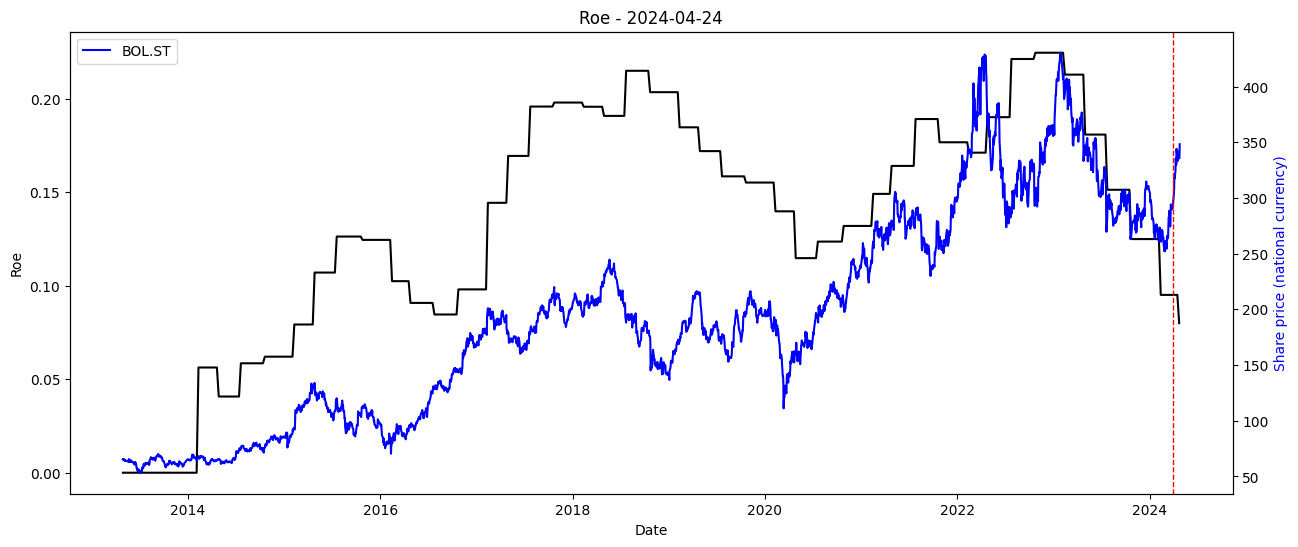

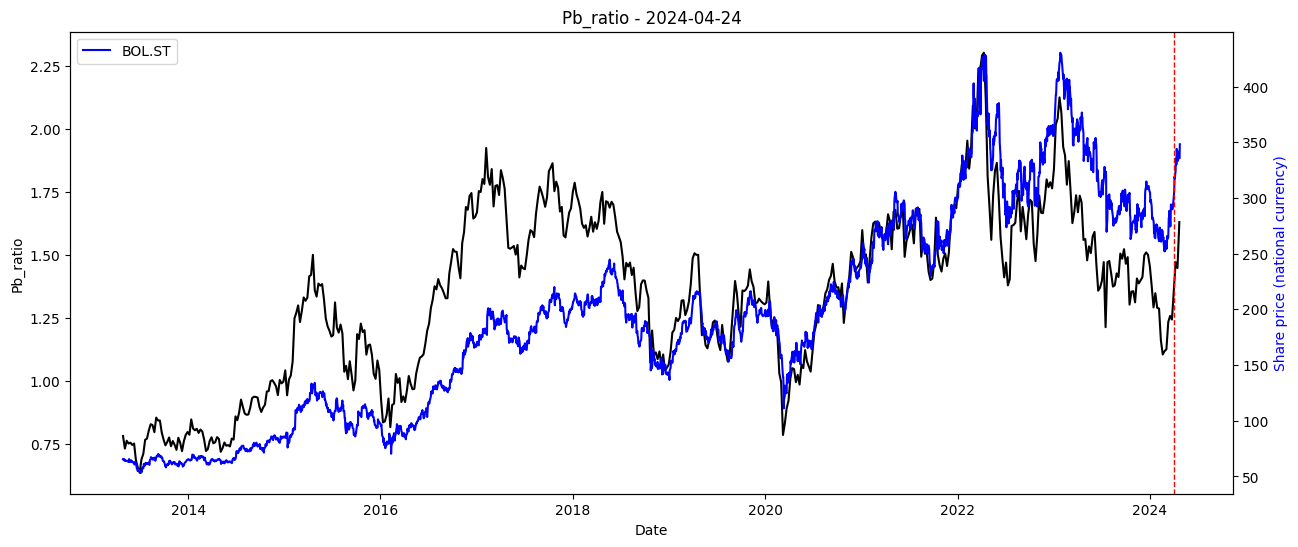

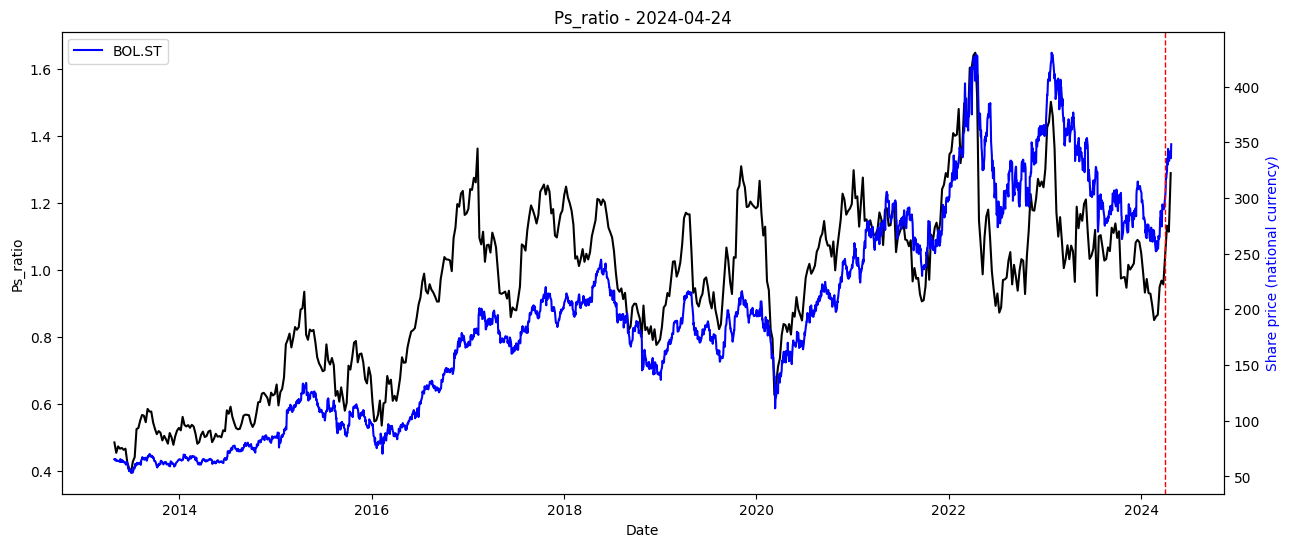

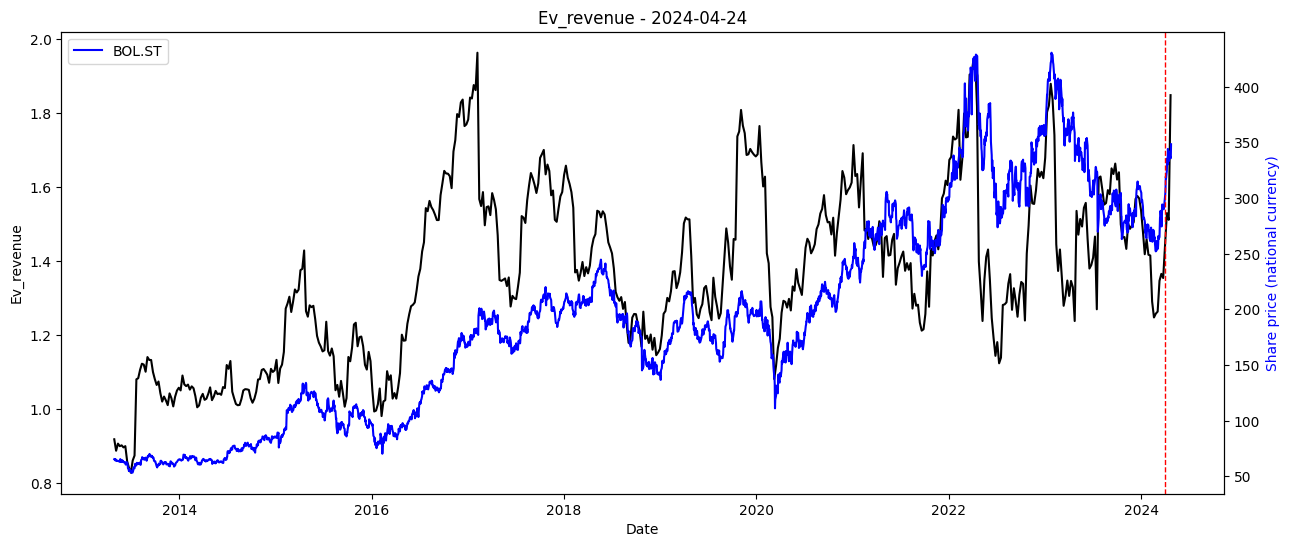

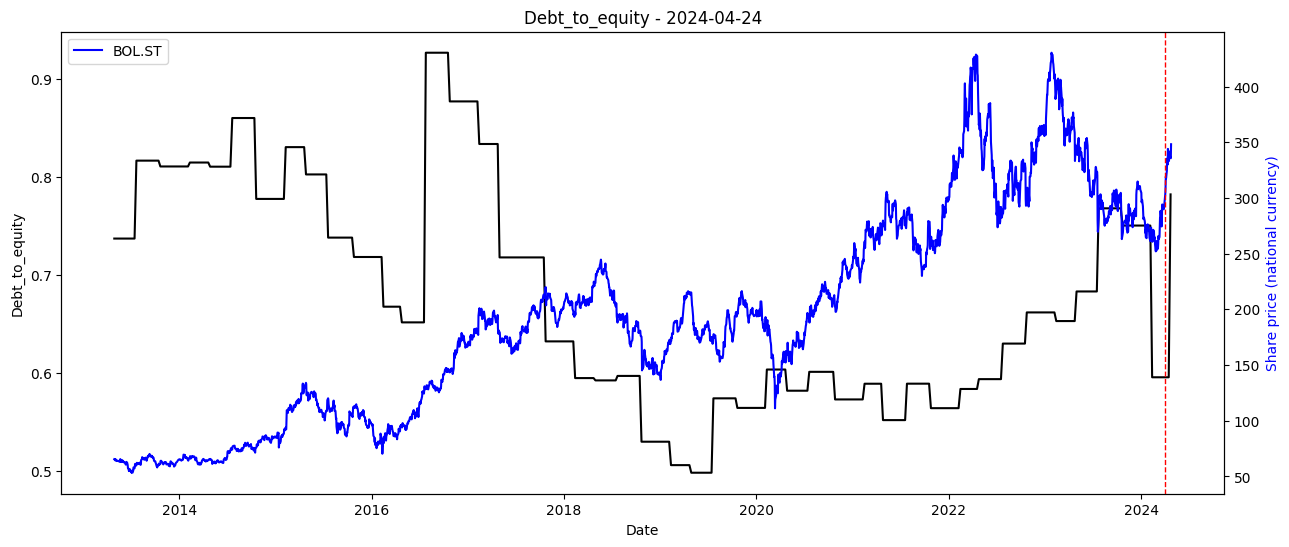

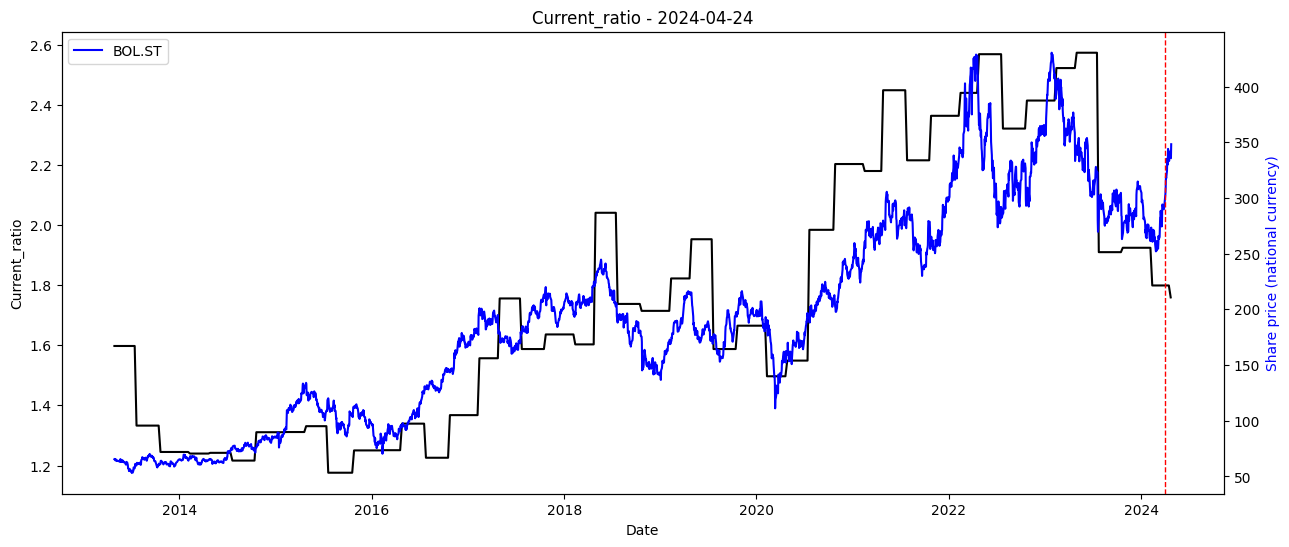

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )